In [1]:
from figures_handler import method_colors as method_colors
from figures_handler import method_names as method_names
from figures_handler import colors as colors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from pandas.plotting import table
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import figures_handler as fh
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
# get the project root
dir_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(dir_path, os.pardir))

experiment_directory = os.path.join(project_root, 'experiments_settings', "experiments_meta_helpers.csv")
data_folder, results_directory, matches_directory, libraries, library_names = fh.get_basic_data(project_root)

display(libraries[['Library', 'short_name']])


,Library,short_name
0,GNPS-MSMLS,lib1
1,GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE,lib2
2,GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE,lib3
3,BERKELEY-LAB,lib4


In [3]:
cols_compare = ["id_known", "id_unknown"]
cols_val = "is_max"
cols_meta = ['shifted', 'matched', 'weight', 'delta', 'peaks', 'num_helpers', 'shifted_annotated_ambiguity']
target_methods = ['none', 'helpers', 'oracle', 'multiple_random_choice', 'multiple_random_distribution']
target_names = ["MF-H", "MF-O", "RC"]
all_libraries_merged_df = pd.DataFrame()
dfs = {}
for library in library_names:
    print(library)
    df, data, methods = fh.get_all(library, experiment_directory, results_directory)
    for method in target_methods:
        if method not in dfs:
            dfs[method] = data[methods[method]]
        else:
            dfs[method] = pd.concat([dfs[method], data[methods[method]]])

GNPS-MSMLS
GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE
GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE
BERKELEY-LAB


In [4]:
for i in ['helpers', 'none', 'oracle']:
    dfs[i]['shifted_annotated_ambiguity'] = dfs[i]['shifted_annotated_ambiguity'] * dfs[i]['shifted_annotated_ratio'] 
helpers = dfs["helpers"][['id_known', 'id_unknown', 'average_dist_normalized', 'shifted_annotated_ambiguity']].rename(columns={'average_dist_normalized': 'helpers_average_dist_normalized', 'shifted_annotated_ambiguity': 'helpers_shifted_annotated_ambiguity'})
none = dfs["none"][['id_known', 'id_unknown', 'average_dist_normalized', 'shifted_annotated_ambiguity']].rename(columns={'average_dist_normalized': 'none_average_dist_normalized', 'shifted_annotated_ambiguity': 'none_shifted_annotated_ambiguity'})
oracle = dfs["oracle"][['id_known', 'id_unknown', 'average_dist_normalized', 'shifted_annotated_ambiguity']].rename(columns={'average_dist_normalized': 'oracle_average_dist_normalized', 'shifted_annotated_ambiguity': 'oracle_shifted_annotated_ambiguity'})

helpers = helpers[helpers['helpers_shifted_annotated_ambiguity'] > 0]
none = none[none['none_shifted_annotated_ambiguity'] > 0]
oracle = oracle[oracle['oracle_shifted_annotated_ambiguity'] > 0]

In [5]:
def get_diff_merge(df1, df2, name1, name2):
    res = pd.merge(df1, df2, on=['id_known', 'id_unknown'], how='inner')
    difference_in_amibiguity = res['{}_shifted_annotated_ambiguity'.format(name2)] - res['{}_shifted_annotated_ambiguity'.format(name1)] 
    difference_in_evaluation = res['{}_average_dist_normalized'.format(name1)] - res['{}_average_dist_normalized'.format(name2)]
    res['difference_in_amibiguity'] = difference_in_amibiguity
    res['difference_in_evaluation'] = difference_in_evaluation

    return res



In [6]:
merge_helpers_none = get_diff_merge(helpers, none, 'helpers', 'none')
merge_oracle_none = get_diff_merge(oracle, none, 'oracle', 'none')
print(len(merge_helpers_none), len(merge_oracle_none))

7593 7353


In [7]:
def categorize(temp_df, gap, n = 4):
    categorize = [[],[],[],[]]
    gap = 1.5
    for i in range(n):
        if i == 0:
            categorize[i] = temp_df[temp_df['difference_in_amibiguity'] < gap]
        elif i < n-1:
            categorize[i] = temp_df[(temp_df['difference_in_amibiguity'] < gap * (i+1)) & (temp_df['difference_in_amibiguity'] >= gap * i)]
        else:
            categorize[i] = temp_df[temp_df['difference_in_amibiguity'] >= gap * i]
        
        # drop nan values
        categorize[i] = categorize[i].dropna()

    category_values = np.zeros((3, n))
    for j in range(n):
        category_values[0][j] = len(categorize[j][categorize[j]['difference_in_evaluation'] > 0])
        category_values[1][j] = len(categorize[j][categorize[j]['difference_in_evaluation'] == 0])
        category_values[2][j] = len(categorize[j][categorize[j]['difference_in_evaluation'] < 0])
    
    return categorize

In [8]:
gap = 1.5
A_helpers = categorize(merge_helpers_none, gap)
A_oracle = categorize(merge_oracle_none, gap)

In [9]:
method_names

{'none': 'MF-N',
 'helpers': 'MF-R',
 'oracle': 'MF-O',
 'sirius': 'MF-S',
 'msbuddy': 'MF-B',
 'cfmid': 'CFM-ID',
 'multiple_random_choice': 'RC',
 'multiple_random_distribution': 'RD'}

0.02929400055958157 0.011657960266157804
0.07634183881234136 0.035466363318784944
0.07537192913574575 0.056148191828038256
0.11853927446480997 0.059700976748992496


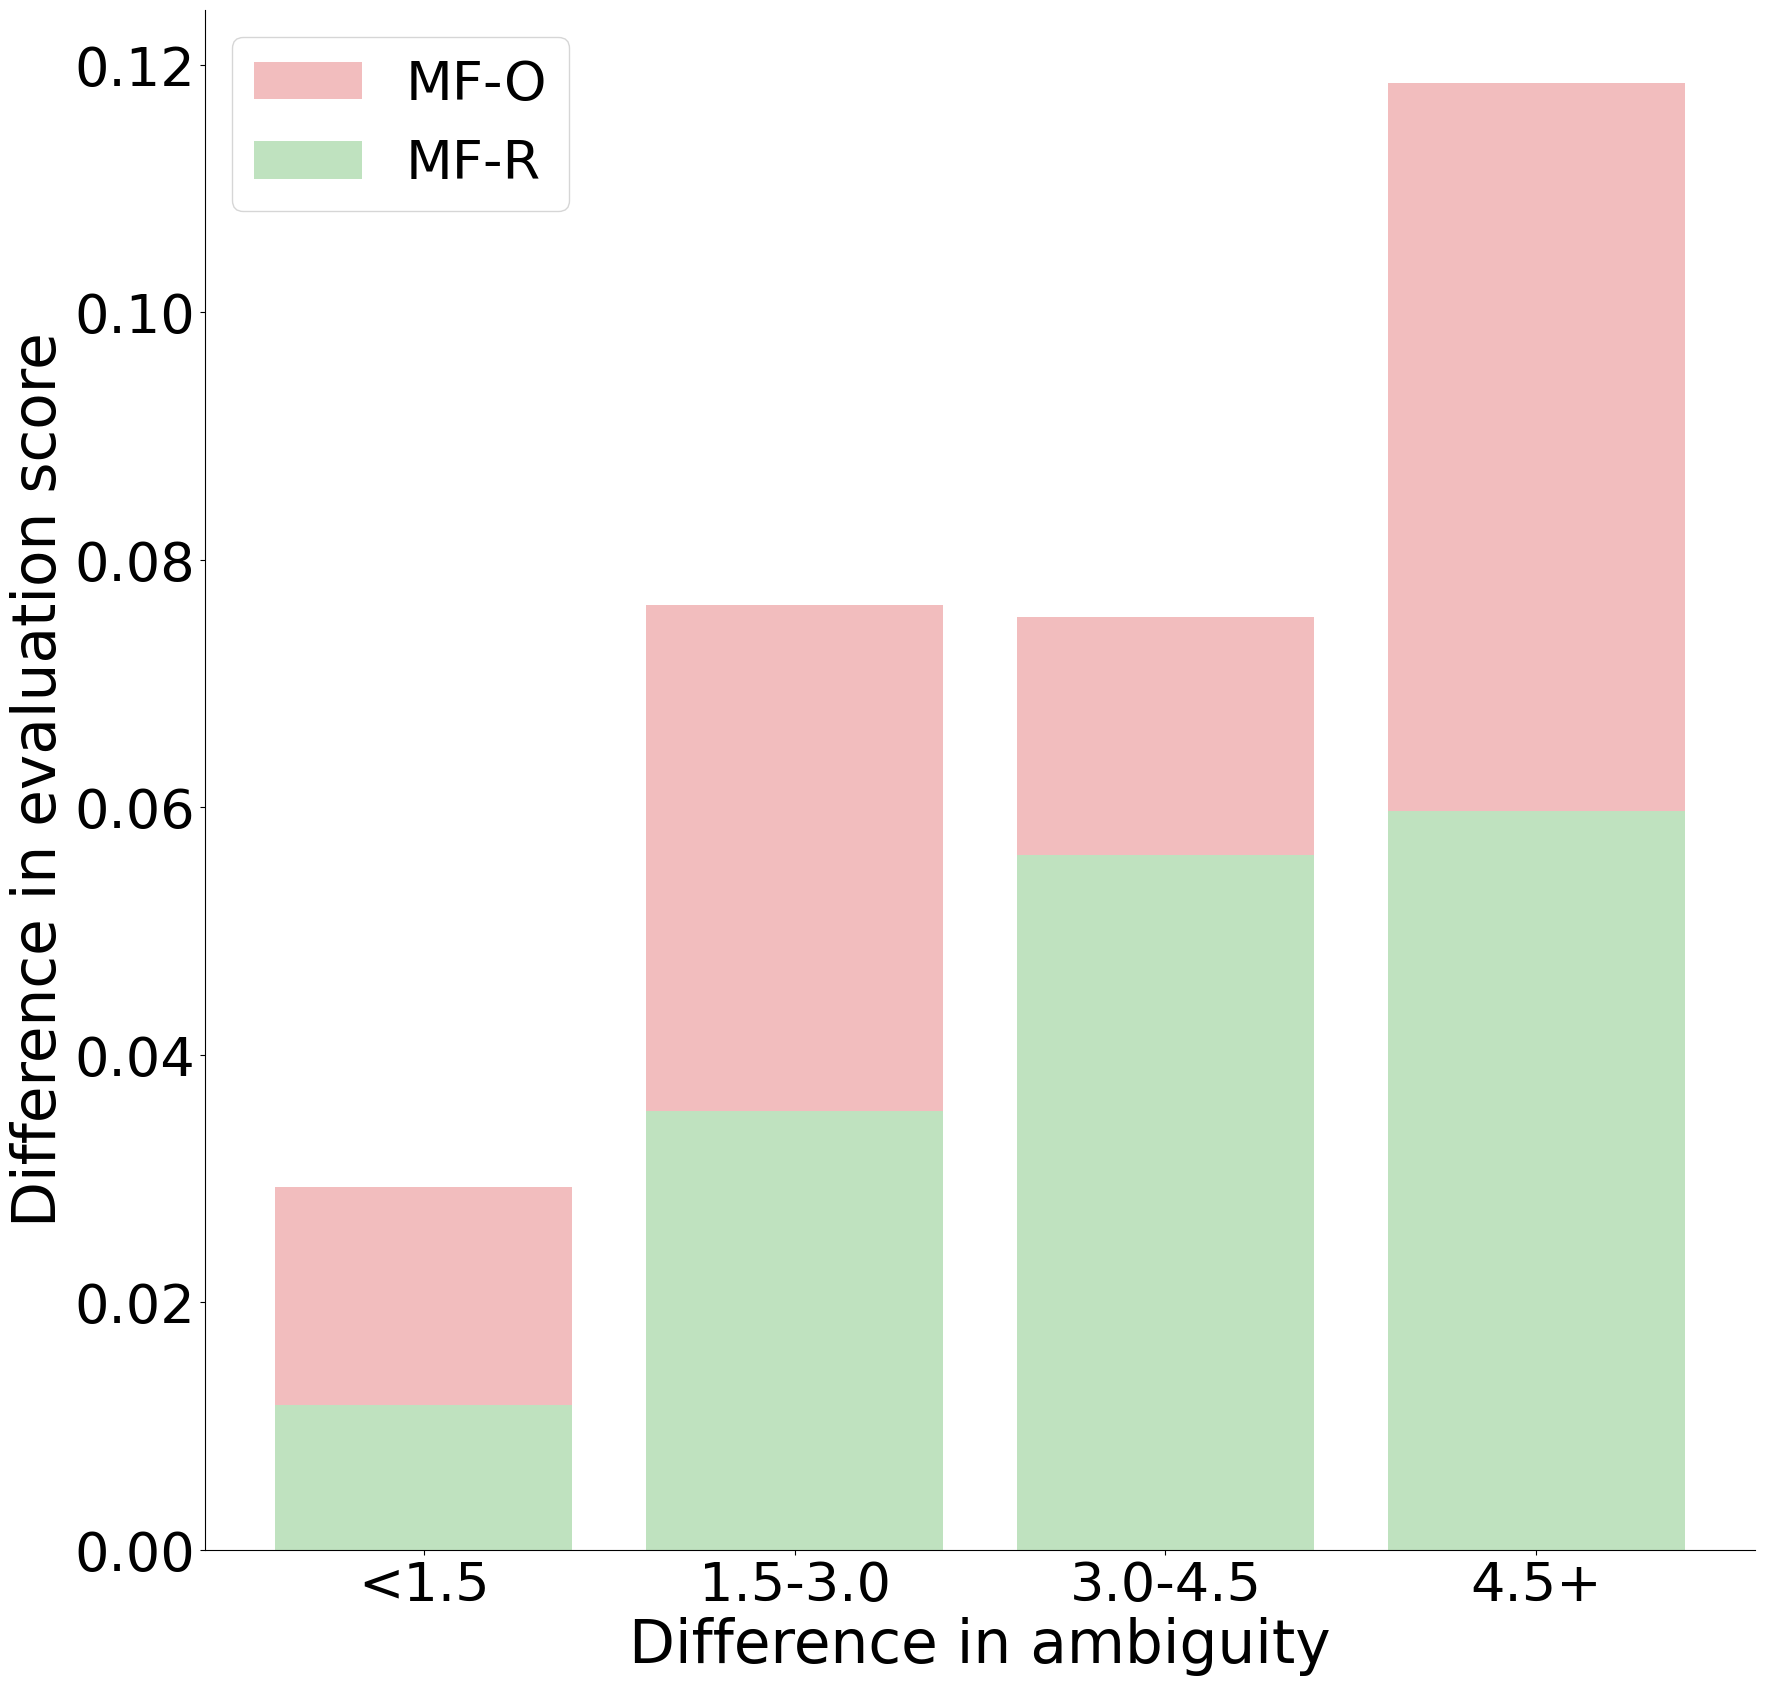

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
for i in range(4):
    ax.bar(i, np.mean(A_oracle[i]['difference_in_evaluation'].values), color=colors[0], label=method_names['oracle'])
    ax.bar(i, np.mean(A_helpers[i]['difference_in_evaluation'].values), color = colors[2], label=method_names['helpers'])
    print(np.mean(A_oracle[i]['difference_in_evaluation'].values), np.mean(A_helpers[i]['difference_in_evaluation'].values))

font_size = 39
ax.set_xticks([0,1,2,3])
ax.set_xticklabels([f'<{gap}', f'{gap}-{2*gap}', f'{2*gap}-{3*gap}', f'{3*gap}+'], fontsize=font_size) # set font size for x axis
# set font size for y axis
for item in ([ax.yaxis.label, ax.xaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
ax.set_xlabel("Difference in ambiguity", fontsize=font_size + 4)
ax.set_ylabel("Difference in evaluation score", fontsize=font_size + 4)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2], labels[0:2], loc='upper left', fontsize=font_size)

# re,pve top border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [13]:
cols_compare = ["id_known", "id_unknown"]
cols_val = "average_dist_normalized"
cols_meta = ['shifted', 'matched', 'weight', 'delta', 'peaks', 'num_helpers']
target_methods = ['none', 'sirius', 'msbuddy', 'helpers', 'oracle']

methods_data = fh.combine_merged_libraries(library_names, experiment_directory, results_directory)
pairs_with_at_least_one_annotated_shift = methods_data["oracle"][methods_data["oracle"]["shifted_annotated_ambiguity"] > 0]
# select only id columns
pairs_with_at_least_one_annotated_shift = pairs_with_at_least_one_annotated_shift[["id_known", "id_unknown"]]

pairs_with_at_least_one_helper = methods_data["oracle"][methods_data["oracle"]["num_helpers"] > 0]
# select only id columns
pairs_with_at_least_one_helper = pairs_with_at_least_one_helper[cols_compare]

[0.175 1.175 2.175 3.175 4.175]


Text(0, 0.5, 'Evaluation Score')

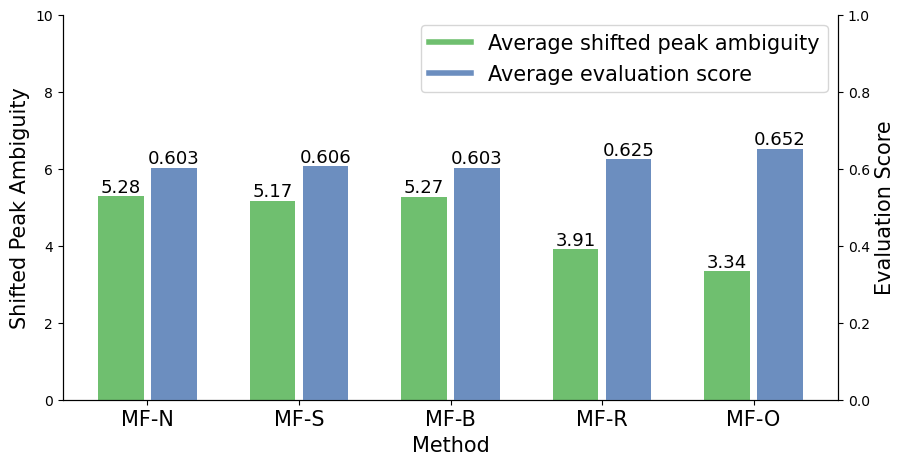

In [14]:
# target_methods = ['none', 'sirius', 'msbuddy', 'helpers', 'oracle']
colors = ['#6c8ebf',  '#6fbf6f', '#bf6f6c']
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax.twinx()
width = 0.3
small_gap = 0.05
font_size = 15

line1 = []
line2 = []
for index, method in enumerate(target_methods):
    data = methods_data[method]
    data = data.merge(pairs_with_at_least_one_annotated_shift, on=cols_compare)
    annotated = data['shifted_annotated_ambiguity']
    ax.bar(index, np.mean(annotated.values), width=width, color=colors[1])
    ax.text(index, np.mean(annotated.values), str(round(np.mean(annotated.values),2)), ha='center', va='bottom', fontsize=13, color='black')
    line1.append(np.mean(annotated.values))
    
    evaluation = data[cols_val]
    ax2.bar(index + width + small_gap, np.mean(evaluation.values), width=width, color=colors[0])
    ax2.text(index + width + small_gap, np.mean(evaluation.values), str(round(np.mean(evaluation.values),3)), ha='center', va='bottom', fontsize=13, color='black')
    line2.append(np.mean(evaluation.values))


x_ticks = np.arange(len(target_methods))
x_ticks = x_ticks + width/2 + small_gap/2
print(x_ticks)
ax.set_xticks(x_ticks)
ax.set_xticklabels([method_names[m] for m in target_methods], fontsize=font_size)

ax.set_ybound(0, 10)
ax2.set_ybound(0, 1)
legend_elements = [Line2D([0], [0], color=colors[1], lw=4, label='Average shifted peak ambiguity'),
                     Line2D([0], [0], color=colors[0], lw=4, label='Average evaluation score')]

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.legend(handles=legend_elements, loc='upper right', fontsize=font_size)

ax.set_xlabel("Method", fontsize=font_size)
ax.set_ylabel("Shifted Peak Ambiguity", fontsize=font_size)
ax2.set_ylabel("Evaluation Score", fontsize=font_size)#, labelpad=20)